<h1><span style="background-color:blue; color:white; padding: 5px;">Notebook à executer lorsqu'il y a de nouvelles données disponible sur data.gouv.fr<br></h1>

In [1]:
from functions2 import *

# Librairies pour la décompression de fichiers et système
import gzip
from io import BytesIO
import sys

# Librairies pour le scrapping
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

# Visualisation de données
import pandas as pd

# datas processing
import datas_processing

2024-03-05 08:25:17.134177: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 08:25:19.186567: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 08:25:19.200893: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-05 08:25:24.338336: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<h2><span style="background-color:grey; color:white; padding: 5px;">Récupération des données disponible et insertion dans la table<br></h2>

In [2]:
# Récupération des codes communes , noms communes et code départements disponibles sur l'api 
url = "https://geo.api.gouv.fr/communes"
response = requests.get(url)
data_communes = response.json()
df_communes = pd.DataFrame(data_communes)
df_communes = df_communes.loc[:,["code","nom","codeDepartement"]]
df_communes = df_communes.drop_duplicates()
df_communes.columns= ["ID_COMMUNE","NAME_COMMUNE","ID_DEPT"]
liste_ID_COMMUNES = df_communes.ID_COMMUNE.to_list()

# URL de la page web
url = 'https://files.data.gouv.fr/geo-dvf/latest/csv/'

response = requests.get(url)
html_content = response.content

# Utilisez BeautifulSoup pour analyser le HTML
soup = BeautifulSoup(html_content, 'html.parser')

# Trouver toutes les balises <a>
a_tags = soup.find_all('a')
annees=[]
# Parcourir chaque balise <a> et extraire le texte ainsi que la date/heure
for a_tag in a_tags:
    name = a_tag.text.strip()
    if name!="../":
        annees.append(name)
print(annees)

url = f'https://files.data.gouv.fr/geo-dvf/latest/csv/{annees[-1]}'
response = requests.get(url)
html_content = response.content
soup = BeautifulSoup(html_content, 'html.parser')

# Trouver la balise 'a' qui contient les liens de téléchargement
csv_element = soup.find('pre').find('a', {'href': "full.csv.gz"})
csv_link = urljoin(url, csv_element['href'])

# Téléchargement des datas et conversion en data frame
csv_response = requests.get(csv_link)
if csv_response.status_code == 200:
    # Utilisation du buffer pour décompresser le fichier .gz
    try :
        with BytesIO(csv_response.content) as file_buffer:
            with gzip.GzipFile(fileobj=file_buffer, mode='rb') as gz_file:
                df = pd.read_csv(gz_file, low_memory=False)
    except Exception as e:
        print("Erreur dans la transformation des données en data frame :",e)

# Selection des données
df = datas_processing.select_datas(df)

# Gestion des valeurs manquantes :
df = datas_processing.nan_management(df)

# Adaptation des données du data frame au format de la base de données
df = datas_processing.format_data(df)

# Groupement des données sur une seule ligne par id_mutation (vente)
df = datas_processing.grouped_datas(df)

# Adaptation des données avec les variables et clés étrangères de la bdd
df = datas_processing.features_and_foreign_keys(df,liste_ID_COMMUNES)

#Suppression des lignes dupliquées
df = df.drop_duplicates()

df.head()

['2018/', '2019/', '2020/', '2021/', '2022/', '2023/']
Nombre de lignes ne pouvant être insérées : 23049


,DATE_MUTATION,MONTANT,NUMERO_RUE,RUE,CODE_POSTAL,ID_COMMUNE,ID_TYPE_BIEN,NB_PIECES,SURFACE_BATI,SURFACE_TERRAIN,LONGITUDE,LATITUDE,DEPENDANCES
0,2023-01-05,1070000,184,ALL DES HETRES,01630,01354,1,8,233,0,6.020119,46.247305,1
1,2023-01-14,206500,294,RTE DE MONTREVEL,01340,01024,2,5,144,3462,5.155628,46.294436,1
2,2023-01-12,449286,339,RTE DE LA LIGNEE,24200,24520,2,4,129,61761,1.206266,44.882129,1
3,2023-01-20,258000,1455,RTE VICTOR HUGO,24330,24053,2,5,108,1905,0.788944,45.129127,0
4,2023-01-18,164400,0,LE BOST,24630,24218,2,4,108,2683,1.083713,45.491963,1


In [3]:
# Date la plus ancienne dans les nouvelles données
date_plus_ancienne_nouvelles_donnees = df['DATE_MUTATION'].min()
print(date_plus_ancienne_nouvelles_donnees)

2023-01-02 00:00:00


In [4]:
date_plus_recente_nouvelles_donnees = df['DATE_MUTATION'].max()
print(date_plus_recente_nouvelles_donnees)

2023-06-30 00:00:00


In [11]:
engine = connection_with_sqlalchemy("datagouv")
query = "SELECT MAX(DATE_MUTATION) DATE_MUTATION FROM VENTES;"
dates_bdd= pd.read_sql(con=engine.connect(), sql=text(query))
# dates_bdd['DATE_MUTATION'] = pd.to_datetime(dates_bdd['DATE_MUTATION'])
date_plus_recente_bdd = dates_bdd['DATE_MUTATION'].min()
print(date_plus_recente_bdd)

2022-12-31 00:00:00


In [29]:
query = "SELECT * FROM VENTES LIMIT 10"
test = pd.read_sql(con=engine.connect(), sql=text(query))
test.head()

,ID_VENTE,MONTANT,NUMERO_RUE,RUE,CODE_POSTAL,LONGITUDE,LATITUDE,DATE_MUTATION,SURFACE_BATI,NB_PIECES,SURFACE_TERRAIN,DEPENDANCES,ID_TYPE_BIEN,ID_COMMUNE
0,1,360000,675,CHE DE LA VAVRE,01160,5.319799,46.089332,2018-07-02,170,7,11578,1,2,01374
1,2,37000,5,RUE D YPRES,01000,5.220403,46.197326,2018-07-06,30,1,0,1,1,01053
2,3,33500,10,RUE PASTEUR,02100,3.283794,49.846301,2018-10-23,88,5,71,0,2,02691
3,4,115000,5085,CHEMIN DE VILLOGNON,16330,0.122281,45.834817,2018-08-01,100,5,2003,0,2,16401
4,5,42500,167,RUE DE PERONNE,02230,3.411908,49.952407,2018-10-26,72,3,659,0,2,02334


In [33]:
#//////////////////////////////////////////////////////////////////////////////
#   Suppression de ventes identiques entre les nouvelles données récupérées
#                    et celles stockées en base de données
#//////////////////////////////////////////////////////////////////////////////
    
with engine.connect() as connection:
    transaction = connection.begin()
    try:
        # Requête pour supprimer les lignes avec une date supérieure ou égale à date_plus_ancienne
        query_delete = text(f"""DELETE FROM VENTES WHERE DATE_MUTATION >= '{date_plus_ancienne_nouvelles_donnees.date()}';""")
        connection.execute(query_delete)

        # Validez la transaction
        transaction.commit()
        print("Transaction validée avec succès.")

    except Exception as e:
        # En cas d'erreur, annulez la transaction
        print(f"Erreur : {e}")
        transaction.rollback()
        print("Transaction annulée.")

Transaction validée avec succès.


In [35]:
#//////////////////////////////////////////////////////////////////////////////
#                   Insertion de nouvelles données
#//////////////////////////////////////////////////////////////////////////////
with engine.connect() as connection:
    transaction = connection.begin()
    try:
        # Insère les données dans la table VENTES
        df.to_sql(name='VENTES', con=engine, if_exists='append', index=False)
        
        # Valide la transaction
        transaction.commit()
        print("Transaction validée avec succès.")

    except Exception as e:
        # En cas d'erreur, annule la transaction
        print(f"Erreur : {e}")
        transaction.rollback()
        print("Transaction annulée.")

    finally:
        engine.dispose()

Transaction validée avec succès.


In [38]:
#//////////////////////////////////////////////////////////////////////////////
#                   Vérification
#//////////////////////////////////////////////////////////////////////////////
query = "SELECT * FROM VENTES ORDER BY DATE_MUTATION DESC LIMIT 5"
datas_added= pd.read_sql(con=engine.connect(), sql=text(query))
datas_added.head()

,ID_VENTE,MONTANT,NUMERO_RUE,RUE,CODE_POSTAL,LONGITUDE,LATITUDE,DATE_MUTATION,SURFACE_BATI,NB_PIECES,SURFACE_TERRAIN,DEPENDANCES,ID_TYPE_BIEN,ID_COMMUNE
0,4533142,160000,343,RUE DES PLANTAGENET,24310,0.636789,45.356361,2023-06-30,105,5,1458,1,2,24064
1,4533151,88000,2699,RTE DE ROYAN,24700,0.121020,45.068727,2023-06-30,63,2,2580,1,2,24165
2,4533159,67000,9008,CHARRIERAS,24750,0.802913,45.206617,2023-06-30,37,2,0,1,1,24557
3,4533141,280000,414,CANTELOUBE SUD,24590,1.262187,44.978926,2023-06-30,125,3,51560,1,2,24412
4,4533145,328850,6,CHE DU GUEL,24130,0.425329,44.850362,2023-06-30,129,5,3706,1,2,24340


<h2><span style="background-color:grey; color:white; padding: 5px;">Stockage de la date du fichier dans une table postgre ...<br></h2>

In [40]:
# Récupération de la date de mise à jour du fichier
date_element = soup.find('pre').contents[-1].strip()
date_element = date_element.split(" ")[0]
print(date_element)

print("Stockage de la date de mise à jour datagouv à faire !!!!!!!!!")

13-Oct-2023
Stockage de la date de mise à jour datagouv à faire !!!!!!!!!


<h2><span style="background-color:grey; color:white; padding: 5px;">Entraînement d'un modèle<br></h2>

In [41]:
from datetime import datetime

# Se baser sur les modèles créé dans mlflow et entraîner un modèle sur les mêmes paramètres
# Enregistrer dans mlflow, experiment : prod_{date_du_jour}
gestion_outliers =True
nb_ventes_mini = 10
tx_filtrage =[nb_ventes_mini,30]
region=''
type_de_bien =''
surface_terrain = True
nb_mois=15
param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'learning_rate': [0.1],
    'min_child_weight': [5],
    'alpha' : [0.5], 
    'lambda' : [0.5]
}
cv=5
uri_tracking = "https://mlflowimmoappkevleg-737621d410d0.herokuapp.com/"
experiment_name = "En_Production"

date_du_jour = datetime.now().strftime('%Y-%m-%d')

# runs à effectuer all_datas 15months all_datas_surface_terrain 15months_surface_terrain)
run_name = f"{date_du_jour}_{region}_{'Appartement_Maison' if len(type_de_bien)==0 else type_de_bien}"\
     f"_{nb_mois}months_GridSearch_GestionOutliers_{'oui' if gestion_outliers==True else 'non'}"\
     f"_{'' if surface_terrain==False else 'surface_terrain'}"

model_name = f"Production_XGB_{run_name}"

where_clause, query = construcion_requete(region,
                        type_de_bien,
                        nb_ventes_mini,
                        surface_terrain,
                        nb_mois)
print(query)


    # Table pour compter le nombre de ventes par commune
    WITH nb_ventes_mini AS(
    SELECT
        ID_COMMUNE AS ID_COMMUNE,
        count(*) nb_ventes_par_commune
    FROM VENTES 
    WHERE DATE_MUTATION >= DATE_SUB((SELECT MAX(DATE_MUTATION) FROM VENTES), INTERVAL 15 MONTH)
    GROUP BY ID_COMMUNE
    )

    # Selection des variables voulues pour l'entraînement du modèle
    SELECT 
        V.SURFACE_BATI,
        V.ID_COMMUNE,
        V.DATE_MUTATION,
        # T.NAME_TYPE_BIEN,
        # R.Name_region,
        V.SURFACE_TERRAIN,
        V.MONTANT
    FROM VENTES V
    INNER JOIN TYPES_BIENS as T ON V.ID_TYPE_BIEN = T.ID_TYPE_BIEN
    INNER JOIN COMMUNES AS C ON V.ID_COMMUNE = C.ID_COMMUNE
    INNER JOIN DEPARTEMENTS AS D ON C.ID_DEPT = D.ID_DEPT
    INNER JOIN REGIONS R ON D.ID_REGION = R.ID_REGION
    WHERE R.Name_region NOT IN('Martinique', 'Guyane', 'La Réunion', 'Mayotte', 'Guadeloupe')  AND V.DATE_MUTATION >= DATE_SUB((SELECT MAX(DATE_MUTATION) FROM VENTES), INTERVAL 15 

In [42]:
df = loading_data(query)

if gestion_outliers==True:
    df=filtrage(df,tx_filtrage,where_clause)

Chargement des données en cours...
Création engine sqlalchemy OK
Chargement des données ok
Il y a 14286 communes avec plus de 10 ventes avant suppression des outliers, pour un total de 988953 ventes
Chargement des données en cours...
Création engine sqlalchemy OK
Chargement des données ok


,ID_COMMUNE,nb_outliers,total_ventes,ventes_restantes,NAME_COMMUNE,pourcentage_ventes_retirees
0,33063,1108,6797,5689,Bordeaux,16.30
1,06088,1059,11579,10520,Nice,9.15
2,92051,943,1364,421,Neuilly-sur-Seine,69.13
3,92012,932,2461,1529,Boulogne-Billancourt,37.87
4,06029,778,4103,3325,Cannes,18.96
5,44109,688,7917,7229,Nantes,8.69
6,31555,663,11601,10938,Toulouse,5.72
7,92044,560,1430,870,Levallois-Perret,39.16
8,78646,524,1422,898,Versailles,36.85
9,94068,460,1575,1115,Saint-Maur-des-Fossés,29.21


Nombre d'outliers : 60157
Nombre de commune avec des outliers : 5680
Nombre de communes contenant des outliers et pour lesquels ilreste plus de 10 ventes après suppression des outliers : 4526
Nombre de communes avec plus de 30% de ventes retirées : 641
Nombre de communes qui seront retirées : 1415
Nombre de ventes restantes après suppression des outlier et après filtrage : 905178
Il y a donc eu 8.47% de lignes supprimées après filtrage


Split des données en cours...


/home/kevin/workspace/PCO/certif_app_immo/model/functions2.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['M2'] = df_train['MONTANT'] / df_train['SURFACE_BATI']


Split OK
Normalisation des données en cours...
Normalisation des données OK
Entraînement en cours ...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END alpha=0.5, lambda=0.5, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=100; total time=   5.8s
[CV] END alpha=0.5, lambda=0.5, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=100; total time=   6.1s
[CV] END alpha=0.5, lambda=0.5, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=100; total time=   6.6s
[CV] END alpha=0.5, lambda=0.5, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=100; total time=   5.6s
[CV] END alpha=0.5, lambda=0.5, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=100; total time=   6.1s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_lambda,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2
0,5.680577,0.341115,0.348382,0.016624,0.5,0.5,0.1,10,5,100,"{'alpha': 0.5, 'lambda': 0.5, 'learning_rate':...",0.650195,0.666614,0.677247,0.684343,0.641624,0.664004,0.016046,1


Graphique en cours...


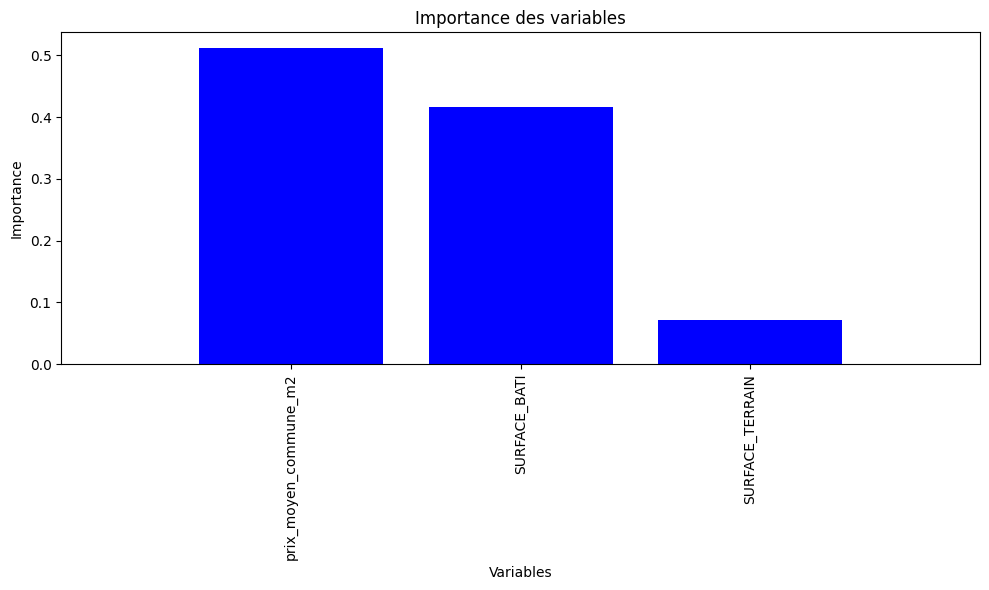

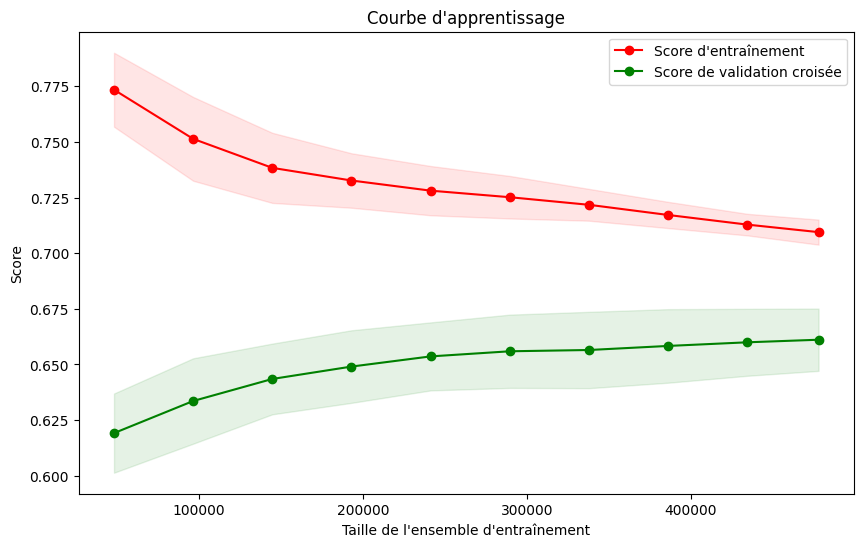

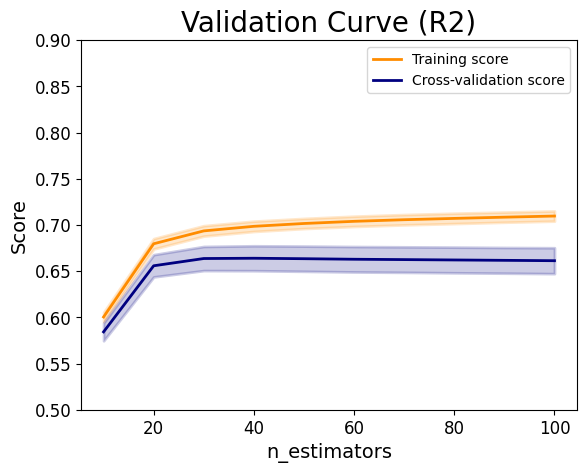

Entraînement OK
Log du modèle et des artifacts en cours...


Successfully registered model 'Production_XGB_2024-03-05__Appartement_Maison_15months_GridSearch_GestionOutliers_oui_surface_terrain'.
2024/03/05 10:22:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Production_XGB_2024-03-05__Appartement_Maison_15months_GridSearch_GestionOutliers_oui_surface_terrain, version 1
Created version '1' of model 'Production_XGB_2024-03-05__Appartement_Maison_15months_GridSearch_GestionOutliers_oui_surface_terrain'.


In [45]:
X_train,y_train, X_test, y_test = split_with_m2(df)

X_train,X_test,encoders,scalers =  encod_scal(X_train,X_test)

model, best_params = train_model_xgboost(X_train,y_train, param_grid, cv)

# Tracé et enregistrement du graphique permettant de savoir si le modèle contient suffisamment de données.
images = plot_validation_learning_curve(model, X_train, y_train)

param_mlflow(uri_tracking=uri_tracking,
        experiment_name=experiment_name, run_name=run_name,
        best_params=best_params,
        model=model, model_name=model_name,
        X_test=X_test, y_test=y_test,
        encoders=encoders,scalers=scalers,
        images = images).log_mlflow()

<h2><span style="background-color:grey; color:white; padding: 5px;">Créer un csv pour être utilisé dans streamlit<br></h2>

In [46]:
# Pour éviter de trop requêter sur rds mais aussi avoir une execution rapide de l'application.
# Récupérer les données Region, département, communes, prix_M²/mois sur la dernière année ou 
# les deux dernières années suivant le modèle utilisé et par type de bien
df.head()

,SURFACE_BATI,ID_COMMUNE,DATE_MUTATION,SURFACE_TERRAIN,MONTANT
0,85,62119,2022-09-08,100,126000
1,76,62510,2022-08-24,440,95000
2,78,62083,2022-08-03,718,206000
3,98,62083,2022-09-06,380,152000
4,84,62250,2022-09-09,600,130000


In [48]:
df["prix_m2"] = df["MONTANT"]/df["SURFACE_BATI"]

In [49]:
df.head()

,SURFACE_BATI,ID_COMMUNE,DATE_MUTATION,SURFACE_TERRAIN,MONTANT,prix_m2
0,85,62119,2022-09-08,100,126000,1482.352941
1,76,62510,2022-08-24,440,95000,1250.000000
2,78,62083,2022-08-03,718,206000,2641.025641
3,98,62083,2022-09-06,380,152000,1551.020408
4,84,62250,2022-09-09,600,130000,1547.619048


In [52]:
data_to_insert = df.loc[:,("ID_COMMUNE","prix_m2")]
data_to_insert = data_to_insert.groupby('ID_COMMUNE')['prix_m2'].mean().round(2).reset_index()
data_to_insert.head()

,ID_COMMUNE,prix_m2
0,01001,2724.92
1,01004,2501.45
2,01005,2934.25
3,01007,2341.14
4,01010,2113.87


In [53]:
data_to_insert.shape

(13843, 2)

<h2><span style="background-color:grey; color:white; padding: 5px;">Stockage du prix au m² dans la table COMMUNES<br></h2>

In [57]:
query = "SELECT count(*) nombre_communes_existantes FROM COMMUNES"
nb_communes_existantes= pd.read_sql(con=engine.connect(), sql=text(query))
nb_communes_existantes.head()

,nombre_communes_existantes
0,35039


In [60]:
print("Nombre de communes dans lesquelles il sera possible de faire une estimation :",\
    data_to_insert.shape[0])
print("Pourcentage de communes dans lesquelles il sera possible de faire une estimation :",\
    round(data_to_insert.shape[0]*100/nb_communes_existantes.iloc[0,0],2),"%")

Nombre de communes dans lesquelles il sera possible de faire une estimation : 13843
Pourcentage de communes dans lesquelles il sera possible de faire une estimation : 39.51 %


In [68]:
#//////////////////////////////////////////////////////////////////////////////
#        Création d'une nouvelle colonne dans la table COMMUNES
#//////////////////////////////////////////////////////////////////////////////
from sqlalchemy import inspect

column_name = 'prix_m2'

with engine.connect() as connection:
    try:
        inspector = inspect(engine)
        columns = inspector.get_columns('COMMUNES')

        # Vérification que la colonne n'existe déjà pas dans la table
        if column_name not in [column['name'] for column in columns]:
            connection.execute(text('ALTER TABLE COMMUNES ADD COLUMN prix_m2 FLOAT NULL;'))
            print("Colonne créée avec succès.")
        else:
            print("La colonne existe déjà dans la table.")

    except Exception as e:
        # En cas d'erreur, annule la transaction
        print(f"Erreur : {e}")
        print("Échec de la création de la nouvelle colonne...Transaction annulée.")

    finally:
        engine.dispose()

La colonne existe déjà dans la table.


In [81]:
#//////////////////////////////////////////////////////////////////////////////
#                          Insertion des données
#//////////////////////////////////////////////////////////////////////////////
data_to_insert_dict = data_to_insert.to_dict(orient='records')

with engine.begin() as connection:
    try :
        for data in data_to_insert_dict:
            query = text("UPDATE COMMUNES SET prix_m2 = :prix_m2 WHERE ID_COMMUNE = :ID_COMMUNE")
            connection.execute(query, {'prix_m2': data['prix_m2'], 'ID_COMMUNE': data['ID_COMMUNE']})
        print("Données insérées avec succès")
    except Exception as e:
        # En cas d'erreur, annule la transaction
        print(f"Erreur : {e}")
        print("Échec de l'envoie de nouvelles données dans la table COMMUNES'")
    finally:
        engine.dispose()

Données insérées avec succès


In [84]:
#//////////////////////////////////////////////////////////////////////////////
#                          Verification
#//////////////////////////////////////////////////////////////////////////////
query = "SELECT * FROM COMMUNES WHERE prix_m2 IS NOT NULL"
verif_insert= pd.read_sql(con=engine.connect(), sql=text(query))
print("Table avec des valeurs non null")
display(verif_insert.head())

query = "SELECT * FROM COMMUNES WHERE prix_m2 IS NULL"
verif_insert= pd.read_sql(con=engine.connect(), sql=text(query))
print("Table avec des valeurs null")
display(verif_insert.head())

Table avec des valeurs non null


,ID_COMMUNE,NAME_COMMUNE,ID_DEPT,prix_m2
0,01001,L'Abergement-Clémenciat,01,2724.92
1,01004,Ambérieu-en-Bugey,01,2501.45
2,01005,Ambérieux-en-Dombes,01,2934.25
3,01007,Ambronay,01,2341.14
4,01010,Anglefort,01,2113.87


Table avec des valeurs null


,ID_COMMUNE,NAME_COMMUNE,ID_DEPT,prix_m2
0,01002,L'Abergement-de-Varey,01,None
1,01006,Ambléon,01,None
2,01008,Ambutrix,01,None
3,01009,Andert-et-Condon,01,None
4,01011,Apremont,01,None
